In [1]:
import pandas as pd
import numpy as np
import pickle

import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')
from utils import FeatureCountPlotter
from utils import DATASETS_METADATA, MODELS_METADATA

In [2]:
def get_n_features(dataset_name: str):
    filename = f"../models/basemodel: DecisionTreeClassifier - metric: kappa - dataset: {dataset_name} - with_drift_metrics.pickle"
    with open(filename, 'rb') as handle:
        model = pickle.load(handle)
    return model.n_features_

In [8]:
PLOT_LEGEND=True
NORMALIZE=True
FINAL_FEATURE_FRACTION = {'powersupply': 50, 'airlines': 65, 'electricity': 15, 'rialto': 10}

N_FEATURES_DICT = {}
for dataset_name in DATASETS_METADATA.keys():
    N_FEATURES_DICT[dataset_name] = get_n_features(dataset_name)

FINAL_N_FEATURES = {dataset_name: int(np.ceil(N_FEATURES_DICT[dataset_name] * FINAL_FEATURE_FRACTION[dataset_name] / 100)) for dataset_name in N_FEATURES_DICT.keys()}
FINAL_N_FEATURES

{'powersupply': 533, 'airlines': 129, 'electricity': 24, 'rialto': 129}

In [4]:
result_df = pd.DataFrame()

for dataset_name, dataset_metadata in DATASETS_METADATA.items():
    for base_model in MODELS_METADATA.keys():
        for feature_perc in range(5, 101, 5):
            filename = f"results_dataframes/base_model: {base_model} - dataset: {dataset_name} - select_k_features: {feature_perc}%.csv"
            this_df = pd.read_csv(filename).dropna()
            this_df["base_model"] = base_model
            this_df["feature_perc"] = feature_perc
            this_df["dataset_name"] = dataset_name
            this_df["original_n_features"] = N_FEATURES_DICT[dataset_name]
            this_df["final_n_features"] = int(np.ceil(N_FEATURES_DICT[dataset_name] * feature_perc / 100))
            result_df = pd.concat([result_df, this_df], ignore_index=True)

In [5]:
result_df.head()

,recall,precision,kappa,f1-score,last_recall,last_precision,last_kappa,last_f1-score,recall_pred_0_with_drift,recall_pred_0_without_drift,...,f1-score_pred_0_without_drift,base_model,feature_perc,dataset_name,original_n_features,final_n_features,auc,last_auc,auc_pred_0_with_drift,auc_pred_0_without_drift
0,0.14,0.14,0.104167,0.14,0.11,0.11,0.072917,0.11,0.166929,0.126894,...,0.126894,RandomForestClassifier,5,powersupply,1065,54,NaN,NaN,NaN,NaN
1,0.12,0.12,0.083142,0.12,0.11,0.11,0.072917,0.11,0.111111,0.075006,...,0.075006,RandomForestClassifier,5,powersupply,1065,54,NaN,NaN,NaN,NaN
2,0.08,0.08,0.038261,0.08,0.11,0.11,0.072917,0.11,0.107524,0.055504,...,0.055504,RandomForestClassifier,5,powersupply,1065,54,NaN,NaN,NaN,NaN
3,0.04,0.04,0.000000,0.04,0.11,0.11,0.072917,0.11,0.097371,0.052012,...,0.052012,RandomForestClassifier,5,powersupply,1065,54,NaN,NaN,NaN,NaN
4,0.03,0.03,0.000000,0.03,0.11,0.11,0.072917,0.11,0.106608,0.048822,...,0.048822,RandomForestClassifier,5,powersupply,1065,54,NaN,NaN,NaN,NaN


# Number of features results

In [6]:
group_col = "final_n_features"
n_feat_plotter = FeatureCountPlotter(result_df, group_col)
n_feat_plotter.fit()

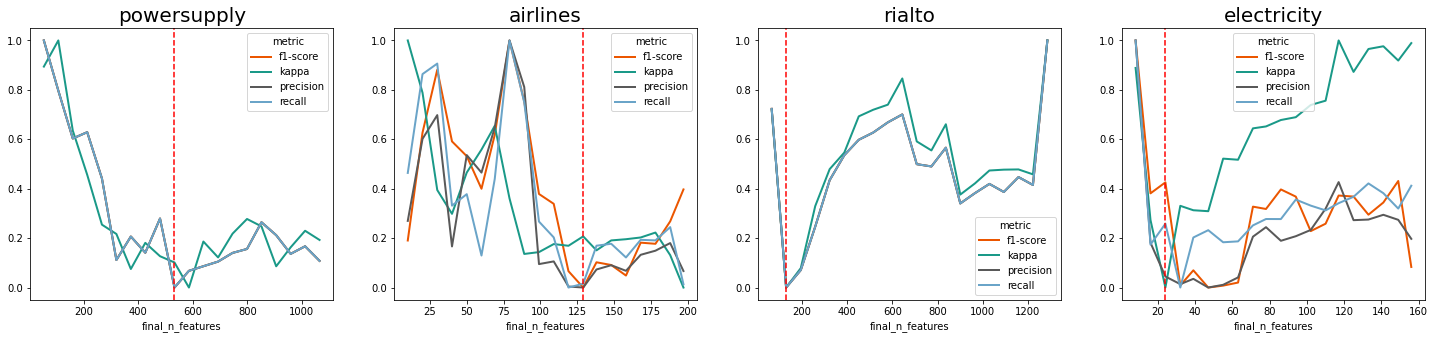

In [9]:
n_feat_plotter.plot(multiple_lines_col="metric", filter_col = "dataset_name", ref_line_dict=FINAL_N_FEATURES, plot_legend=PLOT_LEGEND, normalize=NORMALIZE)

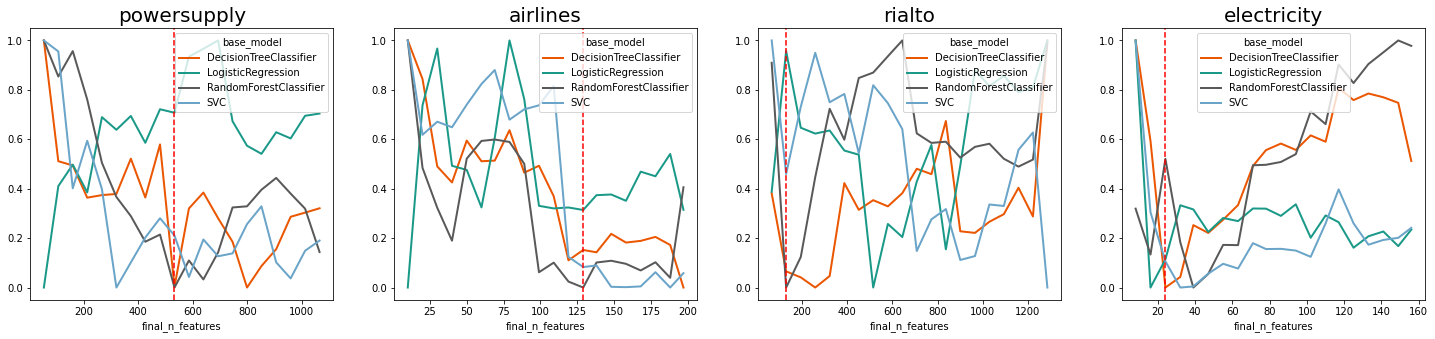

In [10]:
n_feat_plotter.plot(multiple_lines_col="base_model", filter_col = "dataset_name", ref_line_dict=FINAL_N_FEATURES, plot_legend=PLOT_LEGEND, normalize=NORMALIZE)

# Feature fraction results

In [11]:
group_col = "feature_perc"
plotter = FeatureCountPlotter(result_df, group_col)
plotter.fit()

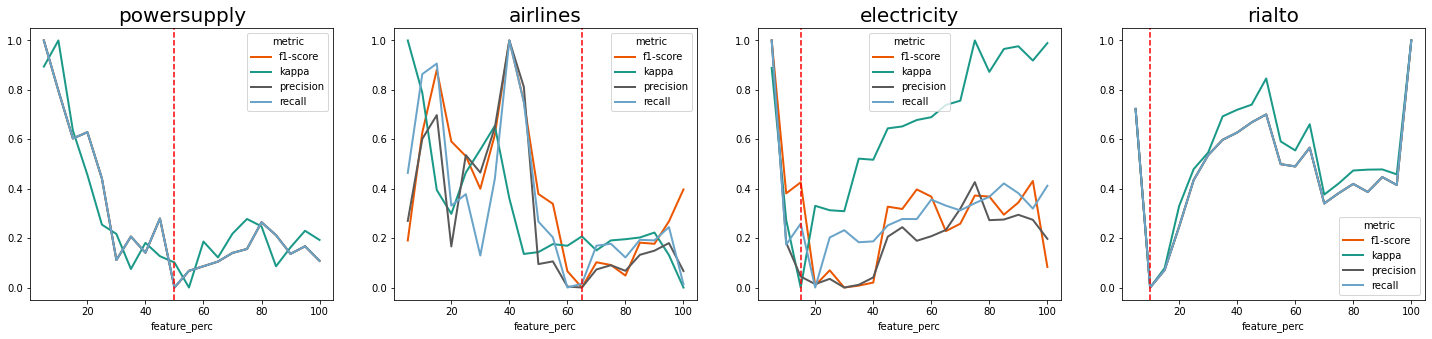

In [12]:
plotter.plot(multiple_lines_col="metric", filter_col = "dataset_name", ref_line_dict=FINAL_FEATURE_FRACTION, plot_legend=PLOT_LEGEND, normalize=NORMALIZE)

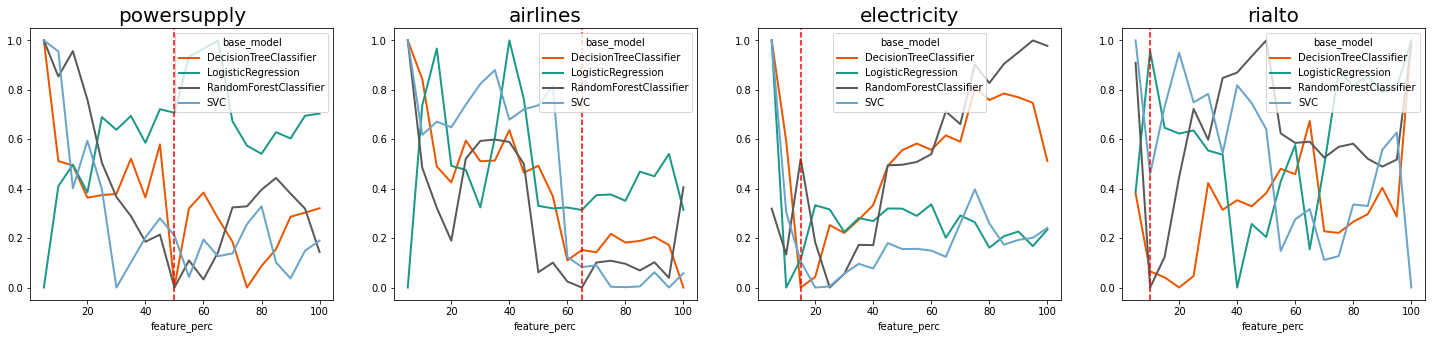

In [13]:
plotter.plot(multiple_lines_col="base_model", filter_col = "dataset_name", ref_line_dict=FINAL_FEATURE_FRACTION, plot_legend=PLOT_LEGEND, normalize=NORMALIZE)

# Get feature fraction with min error

In [14]:
def get_min_mse(dataset_name):
    df = plotter.summarized_df[plotter.summarized_df["dataset_name"] == dataset_name]["proposed_mtl_mse"]
    return df.groupby([plotter.group_col]).sum().reset_index().sort_values("proposed_mtl_mse")["feature_perc"].head(1).values[0]

FINAL_FEATURE_FRACTION = {}
for dataset_name in DATASETS_METADATA.keys():
    FINAL_FEATURE_FRACTION[dataset_name] = get_min_mse(dataset_name)
FINAL_FEATURE_FRACTION

{'powersupply': 50, 'airlines': 65, 'electricity': 15, 'rialto': 10}

# Get number of features with min error

In [18]:
def get_min_mse(dataset_name):
    df = n_feat_plotter.summarized_df[n_feat_plotter.summarized_df["dataset_name"] == dataset_name]["proposed_mtl_mse"]
    return df.groupby([n_feat_plotter.group_col]).sum().reset_index().sort_values("proposed_mtl_mse")["final_n_features"].head(1).values[0]

FINAL_FEATURE_FRACTION = {}
for dataset_name in DATASETS_METADATA.keys():
    FINAL_FEATURE_FRACTION[dataset_name] = get_min_mse(dataset_name)
FINAL_FEATURE_FRACTION

{'powersupply': 533, 'airlines': 129, 'electricity': 24, 'rialto': 129}